#POSE_DETECTION_Detectron2_with_DensePose
1. draws the bounding boxes
2. extracts, displays, and saves the DensePose segmentation masks (both coarse and fine)
3. extracts, displays, and saves the DensePose the U and V coordinate maps.

In [ ]:
import sys, os, distutils.core

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
MODEL_DIR = '/content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/models'
INPUT_DIR = '/content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/input'
# INPUT_DIR = "/content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/input"
OUTPUT_MASK_DIR = "/content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output/posemasks"


if not os.path.exists(OUTPUT_MASK_DIR):
    os.makedirs(OUTPUT_MASK_DIR)


In [ ]:
!python -m pip install pyyaml

In [ ]:
!git clone 'https://github.com/facebookresearch/detectron2.git' $MODEL_DIR/detectron2

Cloning into '/content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/models/detectron2'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 15837 (delta 30), reused 12 (delta 12), pack-reused 15781 (from 2)
Receiving objects: 100% (15837/15837), 6.40 MiB | 8.76 MiB/s, done.
Resolving deltas: 100% (11537/11537), done.
Updating files: 100% (827/827), done.


In [ ]:
!cd $MODEL_DIR/detectron2

In [ ]:
dist = distutils.core.run_setup(os.path.join(MODEL_DIR,"detectron2/projects/DensePose/setup.py"))
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath(os.path.join(MODEL_DIR,"detectron2")))
sys.path.insert(0, os.path.abspath(os.path.join(MODEL_DIR,"detectron2/projects/DensePose")))




  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-install-92ozir86/detectron2_a8feb7d7a4e0464ebf2eb27ba19c68e7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-install-92ozir86/detectron2_a8feb7d7a4e0464ebf2eb27ba19c68e7
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5

In [ ]:
# !pip install -e $MODEL_DIR/detectron2

In [ ]:
# !pip install git+https://github.com/facebookresearch/detectron2@main#subdirectory=projects/DensePose

In [ ]:
!pip install -e $MODEL_DIR/detectron2/projects/DensePose

Obtaining file:///content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/models/detectron2/projects/DensePose
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-install-rqiq8r36/detectron2_74584fe502f34a539bd086002dac6ab6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-install-rqiq8r36/detectron2_74584fe502f34a539bd086002dac6ab6
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done
  Running setup.py develop for detectron2-densepose


In [ ]:
!python -m detectron2.utils.collect_env

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
-------------------------------  -----------------------------------------------------------------
sys.platform                     linux
Python                           3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
numpy                            1.26.4
detectron2                       0.6 @/usr/local/lib/python3.11/dist-packages/detectron2
Compiler                         GCC 11.4
CUDA compiler                    not available
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          2.6.0+cu124 @/usr/local/lib/python3.11/dist-packages/torch
PyTorch debug build              False
torch._C._GLIBCXX_USE_CXX11_ABI  False
GPU available                    No: torch.cuda.is_available() == False
Pillow                           11.1.0
torchvision                      0.21.0+cu124 @/usr/local/lib/python3.11/dist-packages/torchvision
fvcore                           0.1.5.post20221221
iopath                  

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from densepose import add_densepose_config
from densepose.vis.densepose_results import DensePoseResultsVisualizer


In [ ]:
def setup_densepose_model():
    cfg = get_cfg()
    DENSEPOSE_CONFIG_DIR = MODEL_DIR+'/detectron2/projects/DensePose/configs'
    config_path = os.path.join(DENSEPOSE_CONFIG_DIR, "densepose_rcnn_R_101_FPN_s1x.yaml")
    add_densepose_config(cfg)
    cfg.merge_from_file(config_path)
    DENSEPOSE_WEIGHTS_DIR = MODEL_DIR

    # old pkl
    cfg.MODEL.WEIGHTS = os.path.join(DENSEPOSE_WEIGHTS_DIR, "model_final_c6ab63.pkl")
    # new pkl
    # cfg.MODEL.WEIGHTS = os.path.join(DENSEPOSE_WEIGHTS_DIR, "model_final_ad63b5.pkl")
    # advanced pkl
    # cfg.MODEL.WEIGHTS = os.path.join(DENSEPOSE_WEIGHTS_DIR, "DensePose_ResNet101_FPN_32x8d_s1x-e2e.pkl")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Adjust threshold as needed
    cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    predictor = DefaultPredictor(cfg)
    return predictor, cfg

In [ ]:
def run_densepose(image_path):
    # Load the image from disk (BGR)
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Unable to load image: {image_path}")
    # Convert image to RGB for intermediate visualization
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Set up the DensePose model and configuration
    predictor, cfg = setup_densepose_model()
    outputs = predictor(image)
    if "instances" not in outputs:
        raise ValueError("No 'instances' found in the model output.")
    instances = outputs["instances"].to("cpu")

    # Visualize bounding boxes using Detectron2's Visualizer (in RGB)
    metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
    visualizer = Visualizer(image_rgb, metadata=metadata, scale=1.2)
    bbox_overlay = visualizer.draw_instance_predictions(instances).get_image()
    plt.figure(figsize=(10, 10))
    plt.title("Bounding Boxes")
    plt.imshow(bbox_overlay)
    plt.axis("off")
    plt.show()
    bbox_out_path = os.path.join(OUTPUT_MASK_DIR, "densepose_bbox_output.jpg")
    cv2.imwrite(bbox_out_path, cv2.cvtColor(bbox_overlay, cv2.COLOR_RGB2BGR))
    print(f"Bounding box output saved to {bbox_out_path}")

    if not instances.has("pred_densepose"):
        print("No DensePose outputs found in the prediction.")
        return

    # Define a simple helper class for custom DensePose results
    class SimpleDensePoseResult:
        def __init__(self, labels, uv):
            self.labels = labels  # Tensor of shape (H, W) for predicted part labels
            self.uv = uv          # Tensor of shape (2, H, W) for U and V maps

    # Prepare a list to store custom DensePose results (one per instance)
    custom_densepose_results = []

    # Process each detected instance individually
    for idx, dp in enumerate(instances.pred_densepose):
        # Extract fine segmentation logits (expected shape [K, H, W], usually K=25)
        fine_segm = dp.fine_segm
        if fine_segm.dim() == 4 and fine_segm.size(0) == 1:
            fine_segm = fine_segm.squeeze(0)  # Now shape becomes (25, H, W)
        if not isinstance(fine_segm, torch.Tensor):
            fine_segm = torch.stack(fine_segm, dim=0)
        # Compute the fine segmentation mask by taking argmax over channels
        fine_mask = torch.argmax(fine_segm, dim=0).numpy().astype(np.uint8)
        print("Fine segmentation shape after argmax:", fine_mask.shape)

        # Process U and V maps (dp.u and dp.v are expected to have shape (1, 25, H, W))
        u_tensor = dp.u.squeeze(0)  # shape: (25, H, W)
        v_tensor = dp.v.squeeze(0)  # shape: (25, H, W)
        H, W = fine_mask.shape
        # Convert fine_mask to a tensor and flatten for indexing
        fine_mask_tensor = torch.from_numpy(fine_mask).long()  # shape: (H, W)
        fine_mask_flat = fine_mask_tensor.view(1, -1)  # shape: (1, H*W)
        # Gather, for each pixel, the U and V value corresponding to the predicted part
        u_selected = u_tensor.view(25, -1).gather(0, fine_mask_flat).view(H, W)
        v_selected = v_tensor.view(25, -1).gather(0, fine_mask_flat).view(H, W)
        u_np = u_selected.numpy()
        v_np = v_selected.numpy()

        print("Fine mask shape:", fine_mask.shape, "min:", fine_mask.min(), "max:", fine_mask.max())
        print("U map shape:", u_np.shape, "min:", u_np.min(), "max:", u_np.max())
        print("V map shape:", v_np.shape, "min:", v_np.min(), "max:", v_np.max())

        # Display per-instance DensePose outputs
        plt.figure(figsize=(18, 5))
        plt.subplot(1, 3, 1)
        plt.title(f"Instance {idx}: Fine Segmentation")
        plt.imshow(fine_mask, cmap="jet")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.title(f"Instance {idx}: U Coordinates")
        plt.imshow(u_np, cmap="jet")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.title(f"Instance {idx}: V Coordinates")
        plt.imshow(v_np, cmap="jet")
        plt.axis("off")
        plt.show()

        # Save per-instance outputs
        fine_seg_out = os.path.join(OUTPUT_MASK_DIR, f"instance_{idx}_fine_seg.png")
        u_map_out = os.path.join(OUTPUT_MASK_DIR, f"instance_{idx}_u_map.png")
        v_map_out = os.path.join(OUTPUT_MASK_DIR, f"instance_{idx}_v_map.png")
        fine_norm = (fine_mask.astype(np.float32) / (fine_mask.max() + 1e-5)) * 255
        cv2.imwrite(fine_seg_out, fine_norm.astype(np.uint8))
        cv2.imwrite(u_map_out, (u_np * 255).astype(np.uint8))
        cv2.imwrite(v_map_out, (v_np * 255).astype(np.uint8))
        print(f"Saved outputs for instance {idx}:\n  Fine Segmentation: {fine_seg_out}\n  U Map: {u_map_out}\n  V Map: {v_map_out}")

        # Build a custom DensePose result for this instance
        labels_tensor = torch.from_numpy(fine_mask)  # shape: (H, W)
        uv_tensor = torch.stack([u_selected, v_selected], dim=0)  # shape: (2, H, W)
        custom_result = SimpleDensePoseResult(labels_tensor, uv_tensor)
        custom_densepose_results.append(custom_result)

    # Convert predicted boxes (xyxy) to (x, y, width, height)
    boxes_xyxy = instances.pred_boxes.tensor  # shape: (N, 4)
    boxes_xywh_list = []
    for box in boxes_xyxy:
        x1, y1, x2, y2 = box
        boxes_xywh_list.append([x1.item(), y1.item(), (x2 - x1).item(), (y2 - y1).item()])
    boxes_xywh = torch.tensor(boxes_xywh_list)

    # Prepare the tuple expected by the DensePose visualizer: (custom_densepose_results, boxes_xywh)
    results_and_boxes = (custom_densepose_results, boxes_xywh)

    # Generate the combined DensePose overlay using the visualizer.
    # Note: DensePoseResultsVisualizer in the repo does not accept extra arguments.
    # from densepose.vis.densepose_results_visualizer import DensePoseResultsVisualizer
    dp_visualizer = DensePoseResultsVisualizer()
    # IMPORTANT: Pass the original BGR image to the visualizer
    dp_overlay = dp_visualizer.visualize(image, results_and_boxes)
    # If the overlay appears too subtle, manually blend the overlay with the original image.
    # For example, blend 70% of the overlay with 30% of the original:
    blended = cv2.addWeighted(dp_overlay, 0.9, image, 0.1, 0)
    # Convert the blended overlay from BGR to RGB for Matplotlib display
    blended_rgb = cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    # plt.title("DensePose Overlay (Blended)")
    # plt.imshow(blended_rgb)
    # plt.axis("off")
    # plt.show()
    # dp_overlay_out = os.path.join(OUTPUT_MASK_DIR, "densepose_overlay.jpg")
    # cv2.imwrite(dp_overlay_out, blended)  # Save as BGR
    # print(f"DensePose overlay saved to {dp_overlay_out}")


In [ ]:
%matplotlib inline

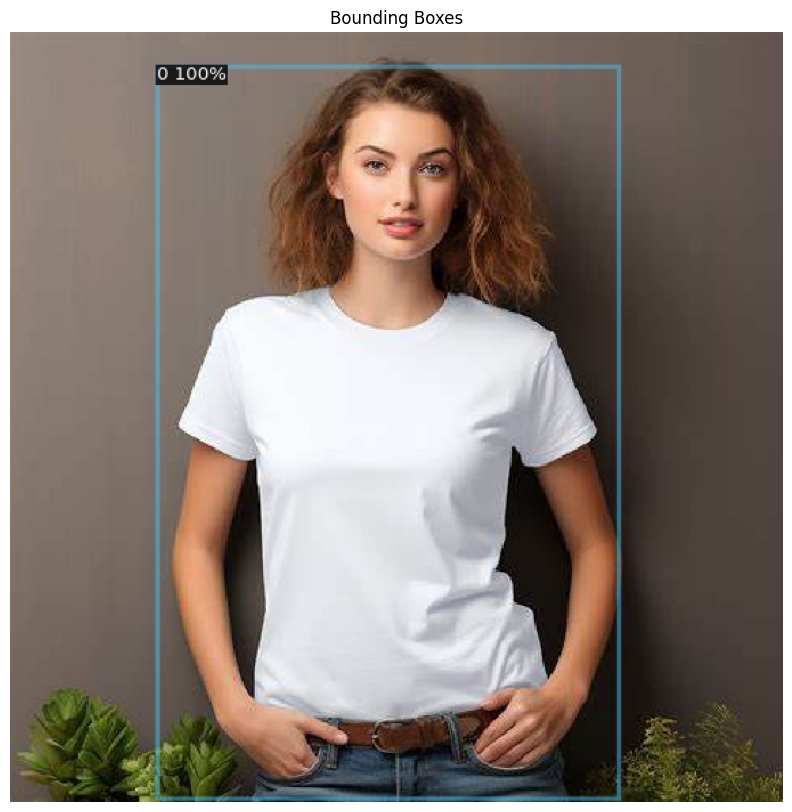

Bounding box output saved to /content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output/posemasks/densepose_bbox_output.jpg
Fine segmentation shape after argmax: (112, 112)
Fine mask shape: (112, 112) min: 2 max: 24
U map shape: (112, 112) min: 0.0054706857 max: 1.0129592
V map shape: (112, 112) min: -0.011099037 max: 0.95960057


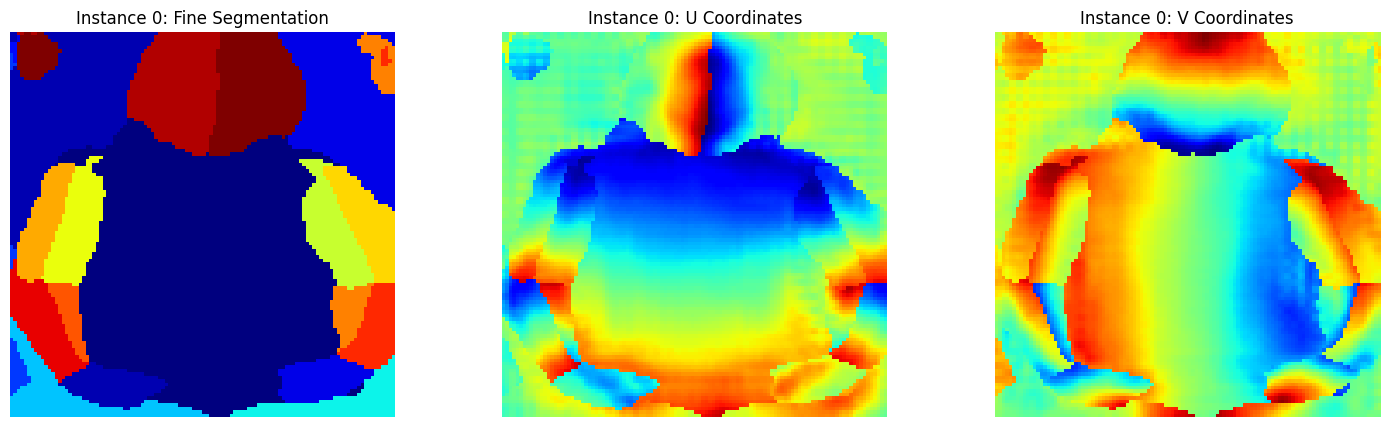

Saved outputs for instance 0:
  Fine Segmentation: /content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output/posemasks/instance_0_fine_seg.png
  U Map: /content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output/posemasks/instance_0_u_map.png
  V Map: /content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output/posemasks/instance_0_v_map.png


<Figure size 1000x1000 with 0 Axes>

In [ ]:
# Main function
if __name__ == "__main__":
    # predictor = setup_densepose_model()
    image_path = os.path.join(INPUT_DIR, "person_image1.jpg")   # Replace with your image path
    run_densepose(image_path)

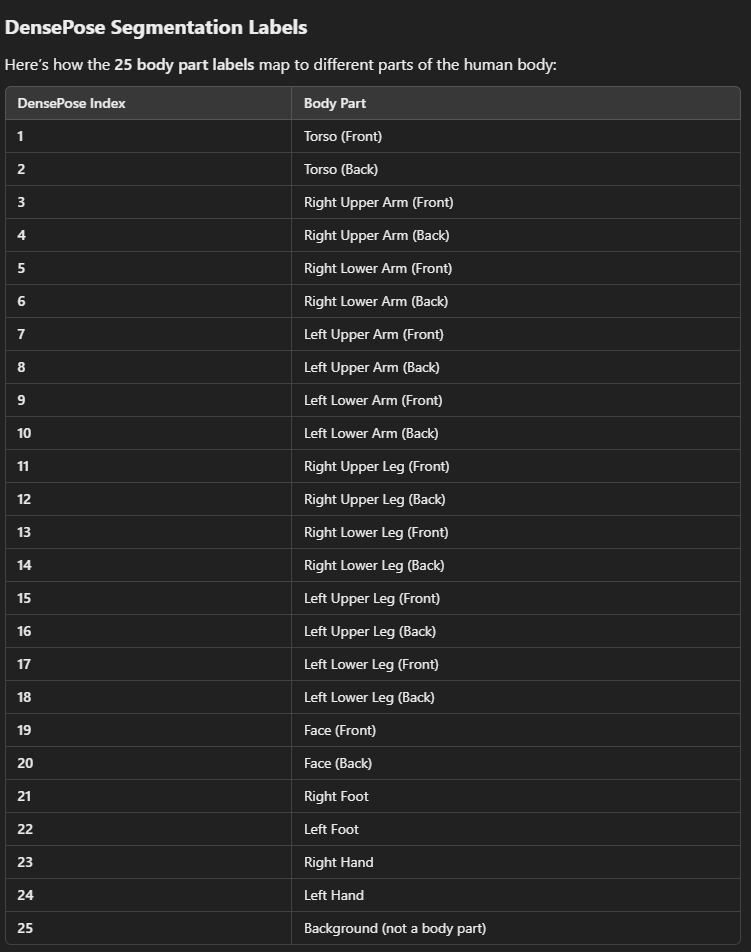